In [1]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

import pyro
import pyro.distributions as dist
from pyro.distributions.torch import Bernoulli
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro import poutine

plt.style.use("seaborn-v0_8")

/env_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def model(n, timesteps, data=None):
    μ_𝛂 = pyro.sample("μ_𝛂", dist.Normal(0, 500.))
    σ_𝛂 = pyro.sample("σ_𝛂", dist.HalfNormal(100.))

    μ_β = pyro.sample("μ_β", dist.Normal(0, 50.))
    σ_β = pyro.sample("σ_β", dist.HalfNormal(5.))
    
    with pyro.plate("data_plate", n):
        𝛂 = pyro.sample("𝛂", dist.Normal(μ_𝛂, σ_𝛂).expand([n]))
        β = pyro.sample("β", dist.Normal(μ_β, σ_β).expand([n]))
    
    σ = pyro.sample("σ", dist.HalfNormal(20))
    μ = 𝛂.unsqueeze(1) * timesteps + β.unsqueeze(1)
    
    with pyro.plate("obs_plate", n, dim=-2):
        obs = pyro.sample("obs", dist.Normal(μ, σ), obs=data)
    
    return obs
    
 

In [3]:
pyro.set_rng_seed(0)
pyro.clear_param_store()
predictive = Predictive(model, num_samples=1)

In [4]:
t = torch.linspace(-100, 100, 50)
n = 100
summary = predictive(n, t)

In [5]:
summary

{'μ_𝛂': tensor([[[-515.0575]]]),
 'σ_𝛂': tensor([[[112.9938]]]),
 'μ_β': tensor([[[67.2372]]]),
 'σ_β': tensor([[[4.9576]]]),
 '𝛂': tensor([[[-482.0360, -463.5437, -434.2825, -621.3121, -558.2177, -753.0212,
           -745.9494, -797.6283, -615.3650, -610.2925, -368.8861, -540.4481,
           -449.9989, -446.4140, -575.4505, -780.5325, -589.8477, -410.1527,
           -426.5307, -450.6449, -469.9419, -465.9727, -578.1141, -572.5704,
           -499.3552, -461.6789, -502.0222, -602.8265, -460.5489, -582.5751,
           -528.9937, -486.5846, -352.5143, -485.4582, -672.7570, -402.4414,
           -485.9054, -520.2358, -567.3278, -626.4573, -344.1014, -560.7491,
           -417.6779, -697.0750, -274.9511, -486.1913, -642.3643, -562.3430,
           -316.7234, -359.2363, -356.7440, -461.9476, -626.0309, -680.6202,
           -431.3249, -489.8837, -525.0524, -427.7582, -331.2259, -487.1753,
           -624.2584, -673.0366, -481.2134, -583.3999, -662.7808, -569.8297,
           -499.9599, 

In [6]:
summary['obs'].size()

torch.Size([1, 100, 50])

In [7]:
data = summary['obs'].squeeze()

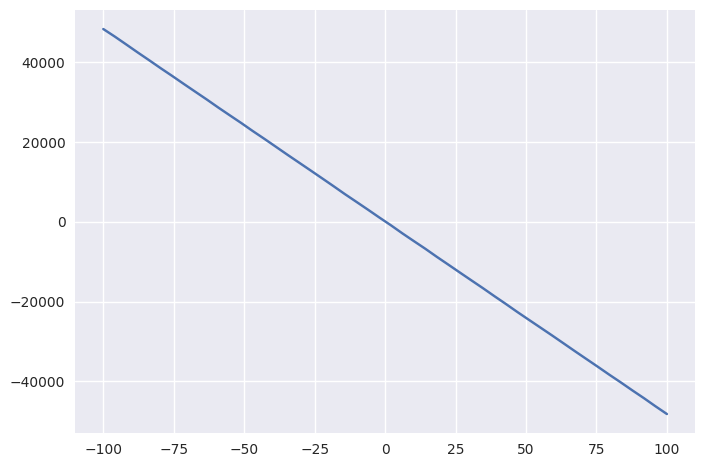

In [8]:
plt.plot(t, data[0])

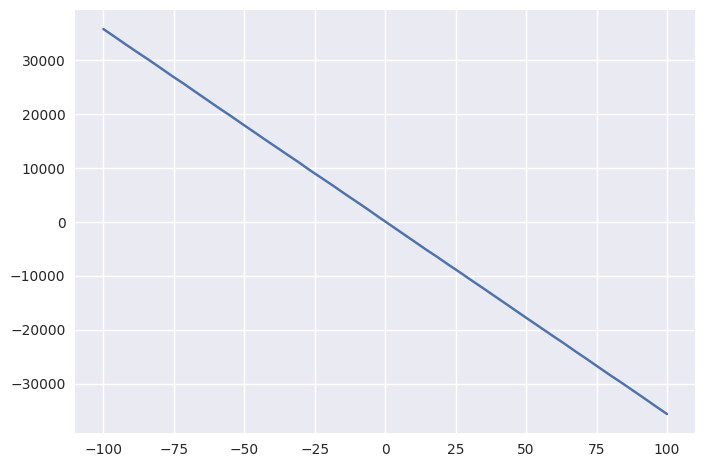

In [9]:
plt.plot(t, data[50])

In [10]:
data[50]

tensor([ 35729.9727,  34264.8125,  32793.6953,  31346.8574,  29939.2227,
         28467.1250,  26977.7910,  25571.6797,  24084.5566,  22615.3555,
         21142.1582,  19720.0156,  18241.9355,  16782.3984,  15316.1904,
         13875.5273,  12428.5117,  11001.5771,   9484.9805,   8074.5498,
          6643.3989,   5162.5229,   3731.7532,   2282.0835,    781.3373,
          -677.1658,  -2142.8669,  -3602.2432,  -5080.2051,  -6481.6982,
         -7959.2231,  -9380.5391, -10862.0059, -12292.6865, -13764.2090,
        -15217.5186, -16687.9121, -18149.5762, -19597.5918, -21055.4570,
        -22476.7168, -23969.8281, -25404.8672, -26884.0723, -28353.1895,
        -29764.0820, -31224.7598, -32685.4434, -34179.8125, -35633.6758])

In [11]:
pyro.clear_param_store()

In [12]:

def model(n, timesteps, data=None):
    μ_𝛂 = pyro.sample("μ_𝛂", dist.Normal(0, 500.))
    σ_𝛂 = pyro.sample("σ_𝛂", dist.HalfNormal(100.))

    μ_β = pyro.sample("μ_β", dist.Normal(0, 50.))
    σ_β = pyro.sample("σ_β", dist.HalfNormal(5.))
    
    with pyro.plate("data_plate", n):
        𝛂 = pyro.sample("𝛂", dist.Normal(μ_𝛂, σ_𝛂).expand([n]))
        β = pyro.sample("β", dist.Normal(μ_β, σ_β).expand([n]))
    
    σ = pyro.sample("σ", dist.HalfNormal(20))
    μ = 𝛂.unsqueeze(1) * timesteps + β.unsqueeze(1)
    
    with pyro.plate("obs_plate", n, dim=-2):
        obs = pyro.sample("obs", dist.Normal(μ, σ), obs=data)
    
    return obs
    
 


def guide(n, timesteps, data=None):
    μ_𝛂_loc = pyro.param("μ_𝛂_loc", torch.tensor(100.0))
    μ_𝛂_scale = pyro.param("μ_𝛂_scale", torch.tensor(1.0), constraint=constraints.positive)
    μ_𝛂 = pyro.sample("μ_𝛂", dist.Normal(μ_𝛂_loc, μ_𝛂_scale))
    
    σ_𝛂_scale= pyro.param("σ_𝛂_scale", torch.tensor(10.0), constraint=constraints.positive)
    σ_𝛂 = pyro.sample("σ_𝛂", dist.HalfNormal(σ_𝛂_scale))

    μ_β_loc = pyro.param("μ_β_loc", torch.tensor(10.0))
    μ_β_scale = pyro.param("μ_β_scale", torch.tensor(1.0), constraint=constraints.positive)
    μ_β = pyro.sample("μ_β", dist.Normal(μ_β_loc, μ_β_scale))
    
    σ_β_scale= pyro.param("σ_β_scale", torch.tensor(10.0), constraint=constraints.positive)
    σ_β = pyro.sample("σ_β", dist.HalfNormal(σ_β_scale))
    
    with pyro.plate("data_plate", n):
        𝛂 = pyro.sample("𝛂", dist.Normal(μ_𝛂, σ_𝛂).expand([n]))
        β = pyro.sample("β", dist.Normal(μ_β, σ_β).expand([n]))
    
    σ = pyro.sample("σ", dist.HalfNormal(20))
    μ = 𝛂.unsqueeze(1) * timesteps + β.unsqueeze(1)
    
    
 

In [18]:
pyro.clear_param_store()
optim = pyro.optim.Adagrad({"lr": 1e-5})
svi = SVI(model, guide, optim, Trace_ELBO())

losses = []
for i in range(100):
    loss = svi.step(n, t, data.unsqueeze(0))
    losses.append(loss)

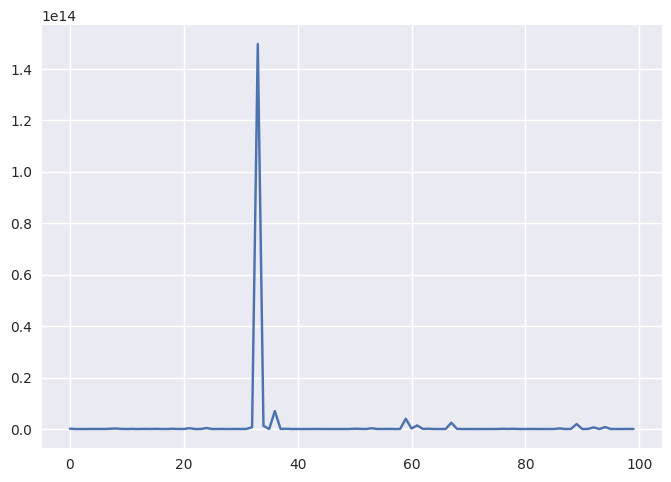

In [19]:
plt.plot(losses)

In [ ]:
for name, param in pyro.get_param_store().items():
    print(param)

tensor(97.8787, requires_grad=True)
tensor(1.1496, grad_fn=<AddBackward0>)
tensor(15.8223, grad_fn=<AddBackward0>)
tensor(12.1040, requires_grad=True)
tensor(0.7158, grad_fn=<AddBackward0>)
tensor(1.7496, grad_fn=<AddBackward0>)
